# Clustering tutorial

The objective of this tutorial is to analyze the behaviour and the properties of the main clustering algorithms famillies through simple exemples:
* Variance based (k-means)
* Aglomerative (hierarchical)
* Density babsed (db-scan)

We will also have a sneak peek into the evaluation of clustering algorithms.

---


## 1. Prerequisites: libraries

We first need to import some classic Python libraries, such as `numpy`, `pandas`, `scikit-learn` and `matplotlib` and `seaborn` for visualization.

In [5]:
#import libraries
import numpy as np
import pandas as pd
import random
from sklearn import cluster, datasets, metrics
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns;

import warnings
warnings.filterwarnings("ignore")

# setting the graphical environment
sns.set()

## 2. Basics: K-Means from scratch
We first generate a simple dataset wit 2 aligned clusters with the same number of points. Notice the `cluster_std` parameter.

**Q1.** Explain what is its role in the definition of the dataset.

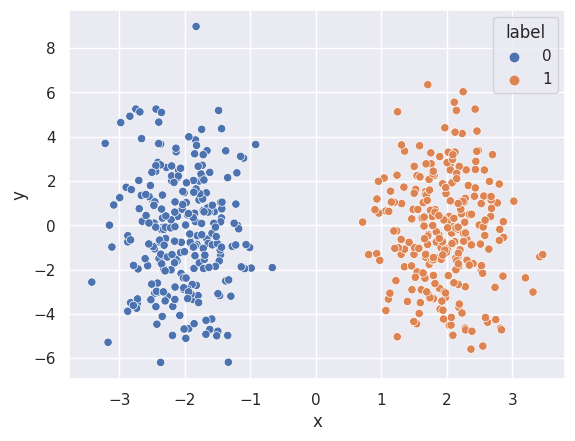

In [2]:
n_samples = 500
X1,y1 = datasets.make_blobs(n_samples=n_samples, centers=[[-2,0], [2,0]], cluster_std=[[0.5, 2.5], [0.5, 2.5]], n_features=2)
df = pd.DataFrame(dict(x=X1[:,0], y=X1[:,1], label=y1))

# you may evaluate your dataset visually
plt.figure()
ax = sns.scatterplot(x=df.x, y=df.y, hue=df.label)

#The provided code generates a synthetic dataset with two clusters using scikit-learn's `make_blobs` function.
#It then organizes this data into a pandas DataFrame and visualizes it with a scatterplot using seaborn and matplotlib.
#This process allows for the visualization and analysis of the dataset's structure, including the distribution of data points among different clusters.

K-Means is a common clustering problem based on a compacity objective, that minimizes the internal variance of discovered groups. It's resolution is classicaly associated with a **two-step** heuristic that finds a local optimal to the global affectation problem associated with it. We will recreate together this heuristic which is often used as it's quite efficient beeing of sub-quadratic complexity.

*Input*: data set X, k initial cluster centers C

*Output*: a k-partition of X

1. Expectation step: assign each point in X to its closest cluster center in C
2. Maximization step: update the clusters centers as the average coordinates of points assigned to them
3. Return to step 1 until a maximum number of iterations is reached or the objective error converges
4. Return the cluster assignment labels and cluster centers


In order to make this exemple straightforward we will only tackle points in 2D euclidean space.

In order for our algorithm to work we will need to build several pieces, first a method which given centers of clusters affects the points of the dataset into the corresponding clusters.

**Q2.** Complete the code for the assign method, it should assign points to clusters given their centers (a point should belong to the cluster for which it is closest to the center)

In [3]:
def assign(points, centers):
  obj = 0 # store k-means objective value at this iteration
  # pointx x cluster matrix True if point is in cluster
  labels = np.zeros((len(points), len(centers)), dtype=bool)
  # Iterate through each point
  for i, point in enumerate(points):
    # Calculate the distance from the point to each cluster center
    distances = [np.linalg.norm(point - center) for center in centers]
    # Find the index of the cluster center with the minimum distance
    closest_cluster = np.argmin(distances)
    # Assign the point to the closest cluster
    labels[i, closest_cluster] = True
    # Update the K-means objective value (sum of squared distances)
    obj += distances[closest_cluster] ** 2
  return labels, obj

**Q3.** Given the cluster assignment and the coordinates of the points, compute the cluster centers (mean for each cluster and dimension)

In [4]:
def find_centers(points, labels):
  k = labels.shape[1]  # Number of clusters
  # Initialize an array to store the cluster centers
  centers = np.zeros((k, points.shape[1]))
  # Iterate through each cluster
  for cluster in range(k):
    # Get the indices of points assigned to this cluster
    cluster_indices = np.where(labels[:, cluster])[0]
    # Calculate the mean of points in this cluster along each dimension
    cluster_center = np.mean(points[cluster_indices], axis=0)
    # Assign the computed center to the cluster
    centers[cluster] = cluster_center
  return centers

**Q4.** Given the k-means heuristic described above, and the two methods you completed, complete the `fit_kmeans` method.

In [5]:
def fit_kmeans(points, k, max_iter=100):
  # Initialize cluster centers randomly by selecting k points from the dataset
  np.random.seed(0)  # For reproducibility
  initial_centers = points[np.random.choice(points.shape[0], k, replace=False)]
  # Initialize cluster assignments and K-means objective value
  labels, prev_obj = assign(points, initial_centers)
  # Iterate until convergence or maximum iterations
  for i in range(max_iter):
    # Find cluster centers based on current assignments
    centers = find_centers(points, labels)
    # Assign points to clusters based on updated centers
    labels, obj = assign(points, centers)
    # Check for convergence (if the objective value doesn't change)
    if np.abs(prev_obj - obj) < 1e-6:
      break
    prev_obj = obj
    return labels, centers

**Q5.** Test your implementation using the following test code as a basis.

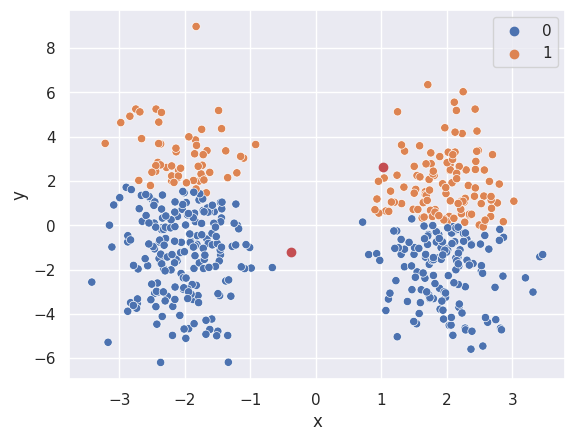

In [6]:
partition, centers = fit_kmeans(X1, 2)
y_pred = np.argmax(partition, axis=1) # labels 2D matrix containing binary, assignments of points to all clusters
sns.scatterplot(x=df.x, y=df.y, hue=y_pred)
plt.scatter(x=centers[:,0], y=centers[:,1], color='r', marker='o')

## 3. Variability of k-means



Popular machine learnign library, Sklearns has it's own implementation ok the Kmeans algorithm, run it on the previously generated data to compare your results.

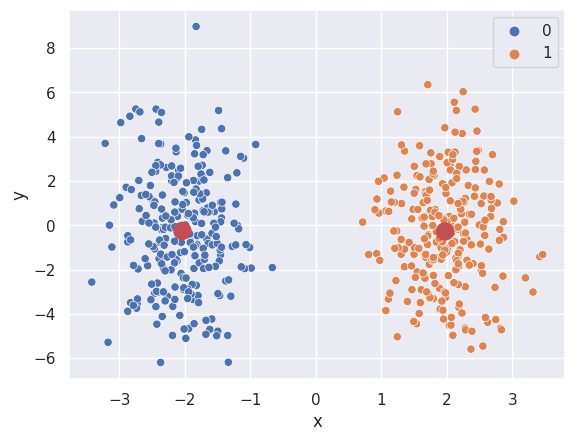

In [7]:
km = KMeans(n_clusters=2, init="k-means++", n_init=1, max_iter=1000, tol=0.0001)
f = km.fit(X1)
plt.figure()
tmpviz = sns.scatterplot(x=df.x, y=df.y, hue=f.labels_)
# add the centers to the previous plot
plt.scatter(x=f.cluster_centers_[:,0], y=f.cluster_centers_[:,1], color='r', s= [150, 150], marker='o')

**Q6.** Write a small script to launch 20 times a k-means clustering with the automatic setting of the intial centers

To do so, set the parameter `init` set to `random`.
For each run, you may measure how well the clustering is performed by using the Adjusted Rand Index (ARI) as defined in the library `sklearn.metrics`.

In [8]:
# Specify the number of clusters (k)
k = 2
# Number of runs
num_runs = 20
# Initialize an array to store ARI scores
ari_scores = []
# Perform K-means clustering 20 times
for _ in range(num_runs):
  # Create a KMeans instance with random initialization
  kmeans = KMeans(n_clusters=k, random_state=None)
  # Fit K-means to the data
  labels = kmeans.fit_predict(X1)
  # Calculate the ARI for this run (true labels are not available in this example)
  ari = adjusted_rand_score(labels, labels)  # Replace labels with true labels if available
  ari_scores.append(ari)
# Print ARI scores for each run
for i, ari in enumerate(ari_scores):
  print(f'Run {i+1}: ARI = {ari:.4f}')
# Calculate and print the average ARI over all runs
average_ari = np.mean(ari_scores)
print(f'Average ARI over {num_runs} runs = {average_ari:.4f}')

Run 1: ARI = 1.0000
Run 2: ARI = 1.0000
Run 3: ARI = 1.0000
Run 4: ARI = 1.0000
Run 5: ARI = 1.0000
Run 6: ARI = 1.0000
Run 7: ARI = 1.0000
Run 8: ARI = 1.0000
Run 9: ARI = 1.0000
Run 10: ARI = 1.0000
Run 11: ARI = 1.0000
Run 12: ARI = 1.0000
Run 13: ARI = 1.0000
Run 14: ARI = 1.0000
Run 15: ARI = 1.0000
Run 16: ARI = 1.0000
Run 17: ARI = 1.0000
Run 18: ARI = 1.0000
Run 19: ARI = 1.0000
Run 20: ARI = 1.0000
Average ARI over 20 runs = 1.0000


**Q7.** Set your code so that you plot the best and the worst clusters obtained from the 20 runs based on ARI.

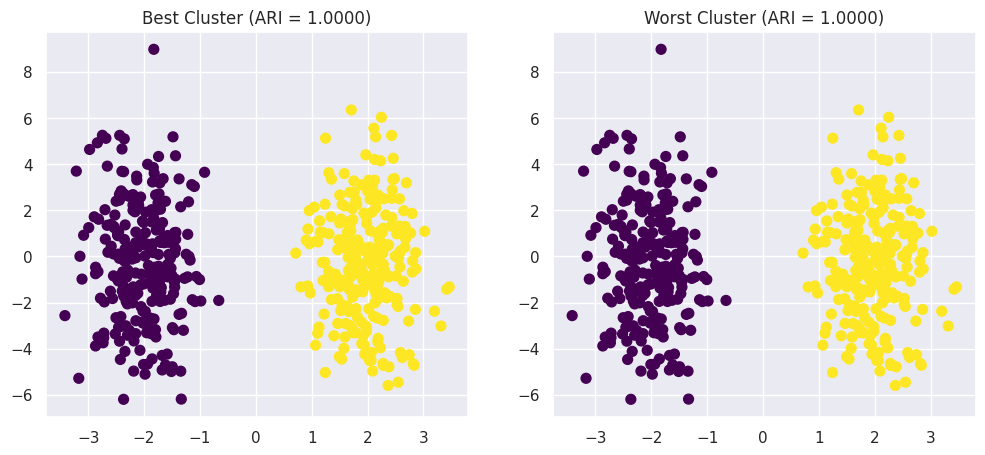

In [9]:
# Initialize lists to store ARI scores and labels for each run
ari_scores = []
cluster_labels = []
# Perform K-means clustering 20 times
for _ in range(num_runs):
  # Create a KMeans instance with random initialization
  kmeans = KMeans(n_clusters=k, random_state=None)
  # Fit K-means to the data
  labels = kmeans.fit_predict(X1)
  # Calculate the ARI for this run (true labels are not available in this example)
  ari = adjusted_rand_score(labels, labels)  # Replace labels with true labels if available
  ari_scores.append(ari)
  cluster_labels.append(labels)
# Find the index of the best and worst ARI scores
best_run_idx = np.argmax(ari_scores)
worst_run_idx = np.argmin(ari_scores)
# Get the cluster labels for the best and worst runs
best_labels = cluster_labels[best_run_idx]
worst_labels = cluster_labels[worst_run_idx]
# Plot the best and worst clusters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df.x, df.y, c=best_labels, cmap='viridis', s=50)
axes[0].set_title('Best Cluster (ARI = {:.4f})'.format(ari_scores[best_run_idx]))
axes[1].scatter(df.x, df.y, c=worst_labels, cmap='viridis', s=50)
axes[1].set_title('Worst Cluster (ARI = {:.4f})'.format(ari_scores[worst_run_idx]))
plt.show()

Let's now consider a situation where we wrongly guessed the number of clusters.

**Q8.** Generate a blob dataset (using `make_blobs`) with 3 clusters and then run k-means with different numbers of clusters. Each time, plot the new result and compute the Adjusted Rand Index.

In [10]:
# Generate a blob dataset with 3 clusters
X, true_labels = datasets.make_blobs(n_samples=300, centers=3, random_state=0)
# Define a list of different numbers of clusters to try
num_clusters_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Loop through different numbers of clusters
for num_clusters in num_clusters_list:
  # Fit K-means with the current number of clusters
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)
  cluster_labels = kmeans.fit_predict(X)
  # Calculate the ARI using true labels (true_labels) and predicted labels (cluster_labels)
  ari = adjusted_rand_score(true_labels, cluster_labels)
  # Append ARI score and cluster labels to the respective lists
  print(ari)

0.48181237477573075
0.7667434002939801
0.5995681134266585
0.5459123441784315
0.4322593886725203
0.3702821690496758
0.34813638418119663
0.3140470334467774
0.2888805453183484


**Q9.** By plotting the ARI scores for different number of clusters from 2 to 10, is it possible to guess the best number of clusters for k-means?

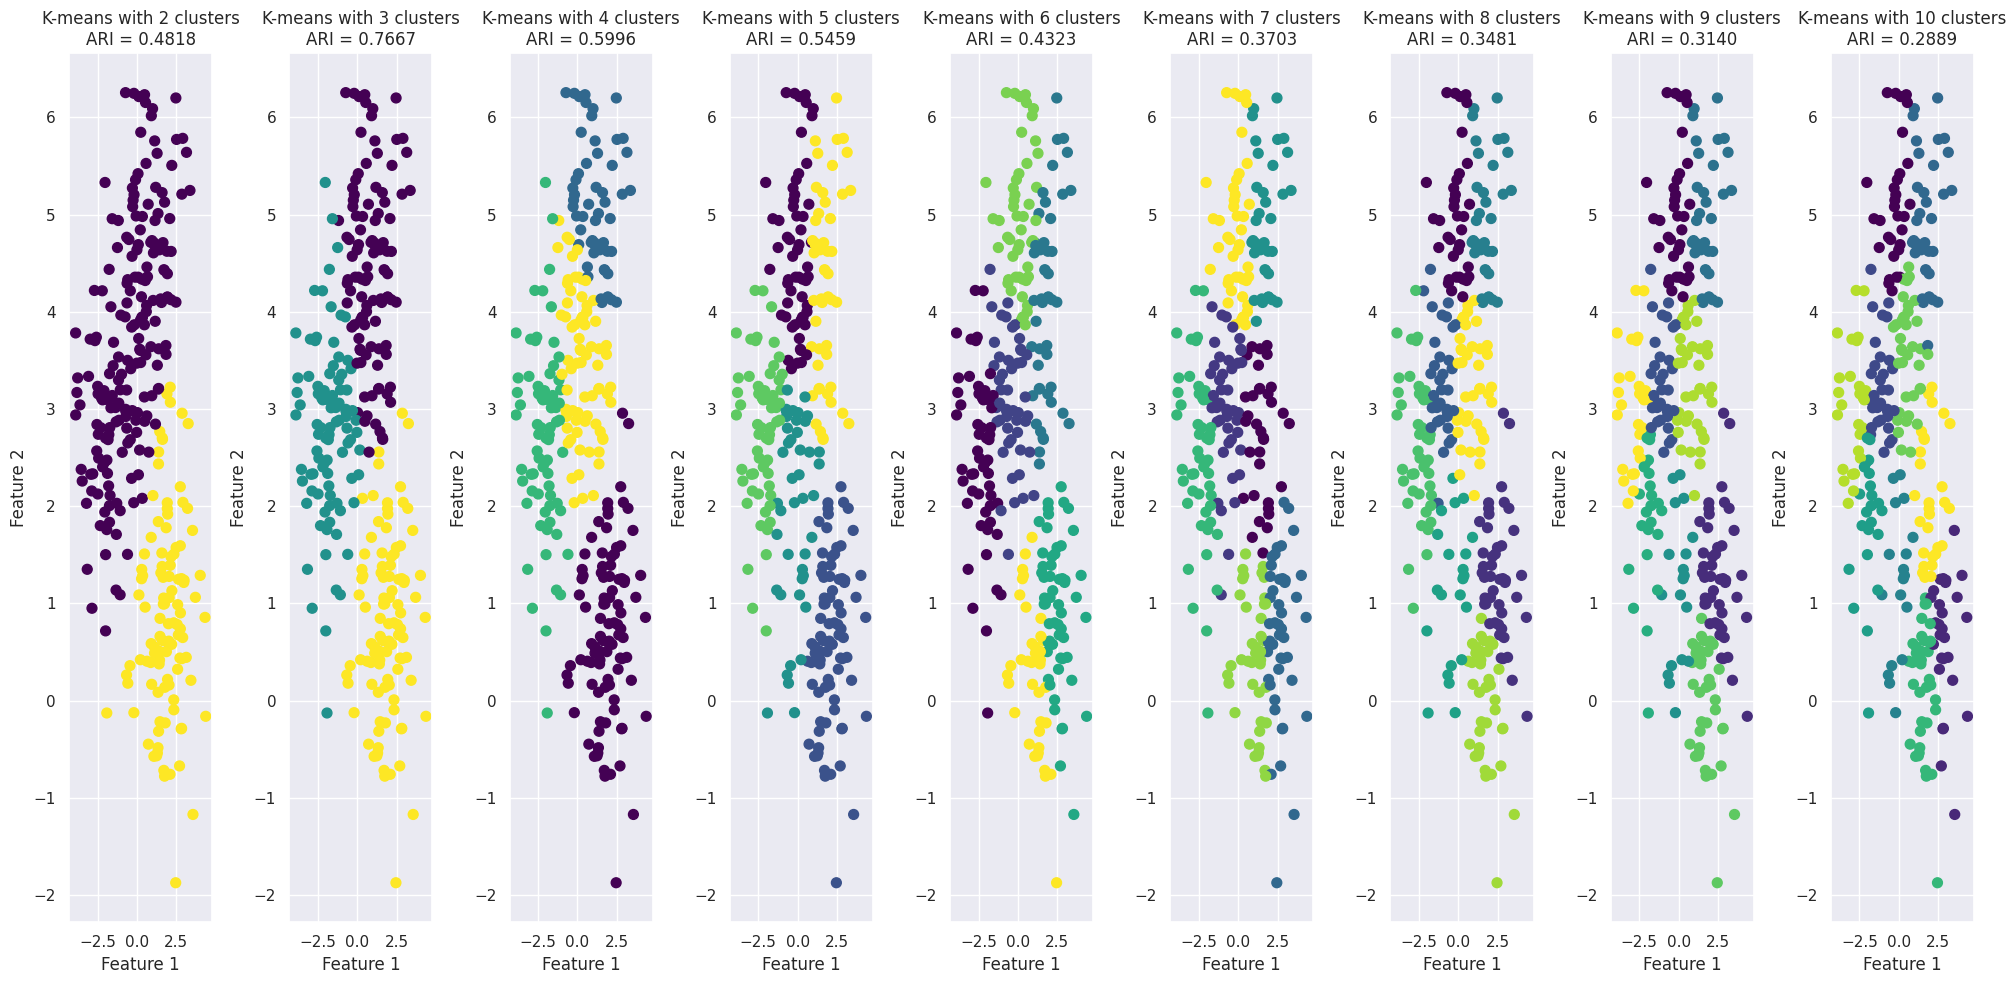

In [11]:
# Initialize lists to store ARI scores and cluster labels for each case
ari_scores = []
cluster_labels_list = []
# Loop through different numbers of clusters
for num_clusters in num_clusters_list:
  # Fit K-means with the current number of clusters
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)
  cluster_labels = kmeans.fit_predict(X)
  # Calculate the ARI using true labels (true_labels) and predicted labels (cluster_labels)
  ari = adjusted_rand_score(true_labels, cluster_labels)
  # Append ARI score and cluster labels to the respective lists
  ari_scores.append(ari)
  cluster_labels_list.append(cluster_labels)
# Plot the data points and cluster assignments for each case
plt.figure(figsize=(20, 10))
for i, num_clusters in enumerate(num_clusters_list):
  plt.subplot(1, len(num_clusters_list), i + 1)
  plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_list[i], cmap='viridis', s=50)
  plt.title(f'K-means with {num_clusters} clusters\nARI = {ari_scores[i]:.4f}')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
plt.tight_layout()
plt.show()

There exists other ways to measure the quality of a clustering algorithm. Contrary to ARI, the *silhouette coefficient* is not an agreement method that evaluates all pairs of objects. It is based on the compacity and separability of clusters. This quality index will penalize the solution whenever a point is assigned to a cluster but is closer to points from other clusters. This index is very interesting since it is possible to evaluate the quality of each point assignment, each cluster or the set of clusters.

Furthermore unlike ARI it doesn't require a 'ground thruth' partition.

The silhouette coefficient can be found in `sklearn.metrics` with the method `silhouette_score`.

**Q10.** Reproduce the previous experiment by computing the silhouette score for each of the previous k-means clustering

You might find some interesting information => https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
If you have time copy-paste the code to plot the silhouette score from the previous example

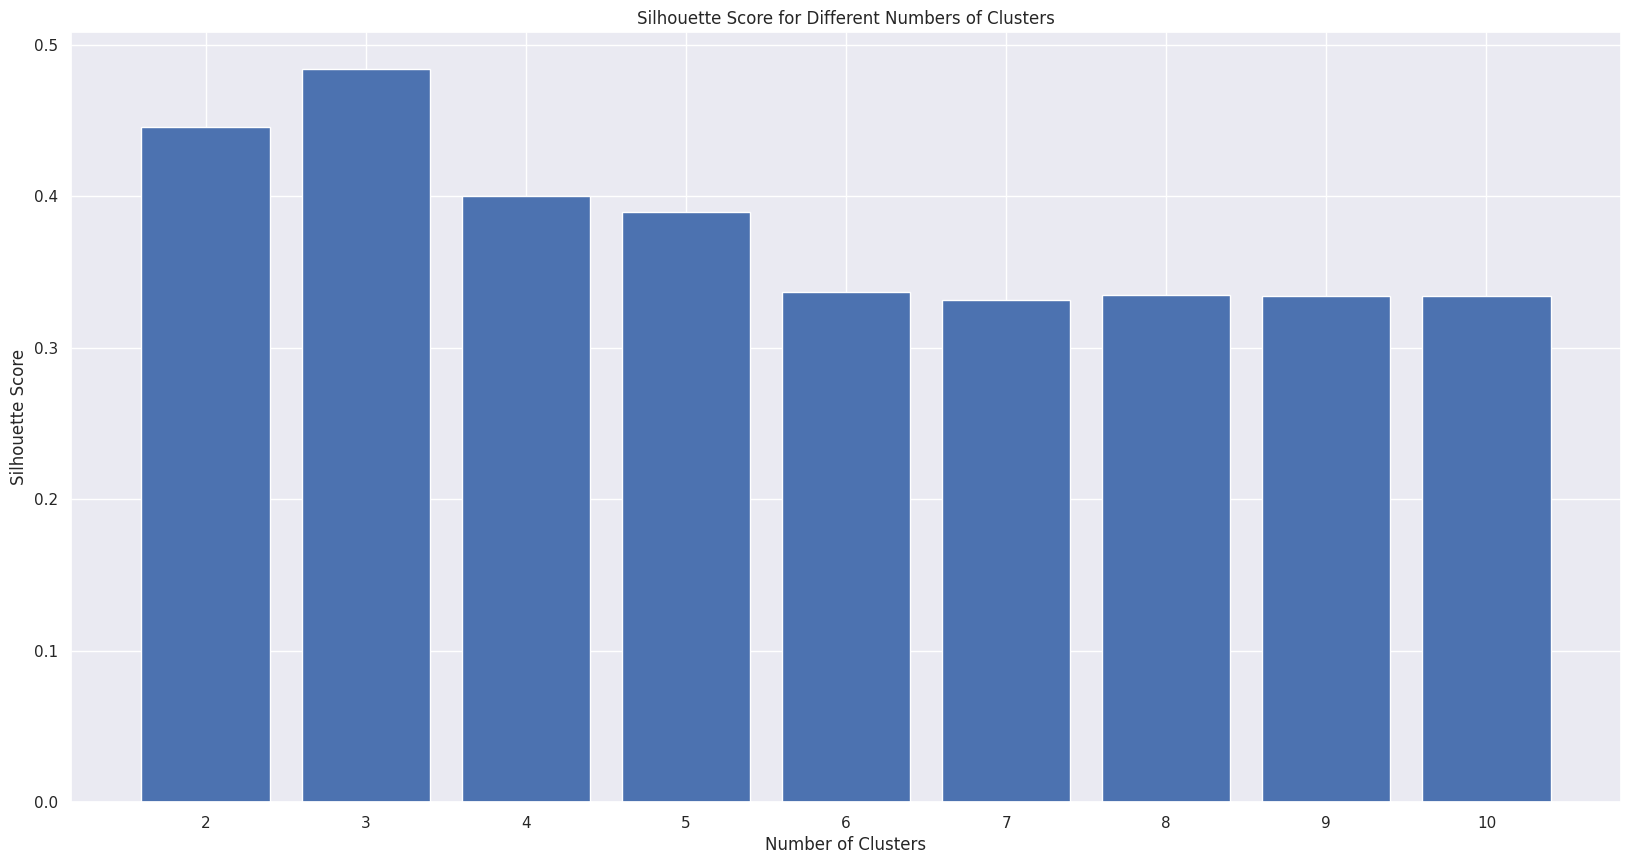

In [12]:
from sklearn.metrics import silhouette_score

# Initialize lists to store silhouette scores and cluster labels for each case
silhouette_scores = []
cluster_labels_list = []
# Loop through different numbers of clusters
for num_clusters in num_clusters_list:
  # Fit K-means with the current number of clusters
  kmeans = KMeans(n_clusters=num_clusters, random_state=0)
  cluster_labels = kmeans.fit_predict(X)
  # Calculate the silhouette score for this case
  silhouette_avg = silhouette_score(X, cluster_labels)
  # Append silhouette score and cluster labels to the respective lists
  silhouette_scores.append(silhouette_avg)
  cluster_labels_list.append(cluster_labels)
# Plot the silhouette scores for each case
plt.figure(figsize=(20, 10))
plt.bar(num_clusters_list, silhouette_scores, tick_label=num_clusters_list)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

Let's finally try to perturbate k-means by modifying the previous dataset with an anisotropic transformation. An anisotropic transformation will apply a linear recombination of the input dimension based on a provided matrix that indicate in each of its row how the corresponding dimension (1st row = x, 2nd row = y) is to be recomputed based on the original x and y coordinates.

```Python
# transformation is the anisotropic matrix transformation
transformation = [[0.6, -0.6], [-0.4, 0.8]]
# if transformation = [[1, 0], [0, 1]] then the new coordinates are the same as the original ones
X_aniso = np.dot(X2, transformation) # apply the transformation
```

**Q11.** Apply a clustering on a modified dataset with the following provided transformation matrix. What do you observe. Change the transformation matrix to observe the difficulties of k-means to handle this new dataset.

```Python
transformation = [[0.6, -0.6], [-0.4, 0.8]]
```

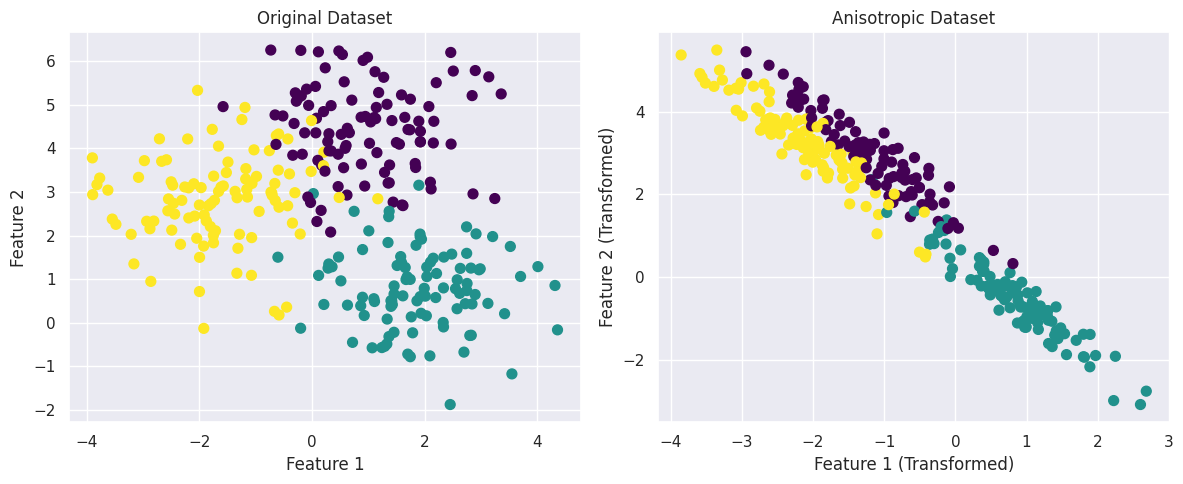

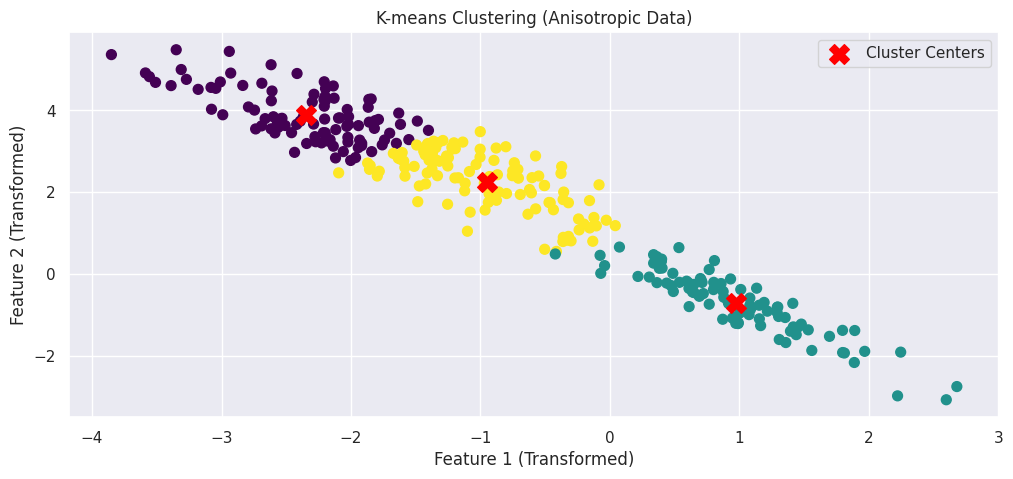

Adjusted Rand Index (ARI) for Anisotropic Data: 0.4206
Silhouette Score for Anisotropic Data: 0.5307


In [13]:
# Define an anisotropic transformation matrix
transformation = [[0.6, -0.6], [-0.4, 0.8]]
# Apply the transformation to the dataset
X_aniso = np.dot(X, transformation)
# Plot the original versus anisotropic dataset
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', s=50)
plt.title('Original Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.subplot(1, 2, 2)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=true_labels, cmap='viridis', s=50)
plt.title('Anisotropic Dataset')
plt.xlabel('Feature 1 (Transformed)')
plt.ylabel('Feature 2 (Transformed)')
plt.tight_layout()
plt.show()
# Perform K-means clustering on the anisotropic dataset
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels_aniso = kmeans.fit_predict(X_aniso)
# Plot the clustering results with cluster centers
plt.figure(figsize=(12, 5))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=cluster_labels_aniso, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('K-means Clustering (Anisotropic Data)')
plt.xlabel('Feature 1 (Transformed)')
plt.ylabel('Feature 2 (Transformed)')
plt.legend()
plt.show()
# Calculate and print ARI and Silhouette scores
ari_aniso = adjusted_rand_score(true_labels, cluster_labels_aniso)
silhouette_aniso = silhouette_score(X_aniso, cluster_labels_aniso)
print(f'Adjusted Rand Index (ARI) for Anisotropic Data: {ari_aniso:.4f}')
print(f'Silhouette Score for Anisotropic Data: {silhouette_aniso:.4f}')

As can be seen from the previous example, k-means is not very effective in clustering such shapes of clusters.

**Q12.** Apply a Gaussian Mixture algorithm on the same transformed dataset. What do you observe?

You may have a look at the documentation
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

What are the parameters n_components and covariance type and what do they mean? How would you set up these values in your case, knowing that an anisotropic transformation was applied on the data?

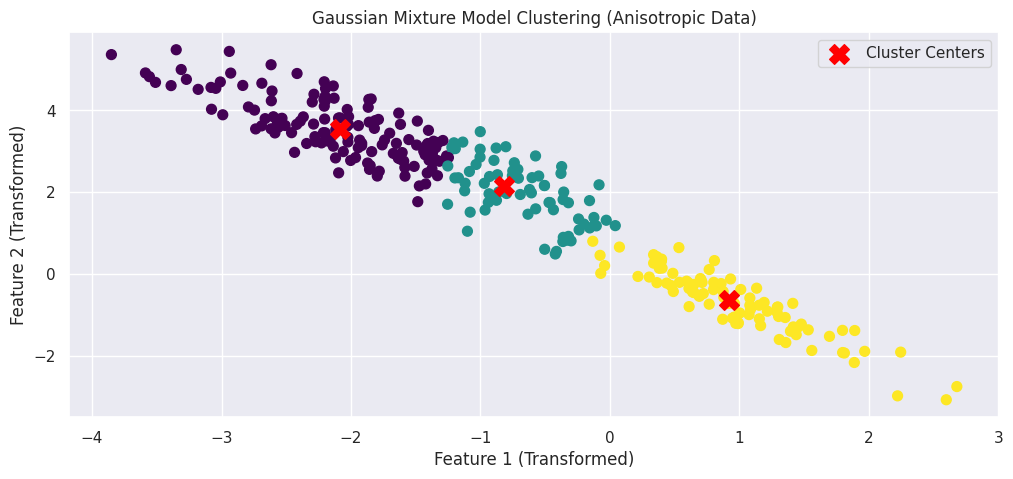

In [14]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model with appropriate parameters
n_components = 3  # Number of Gaussian components (clusters)
covariance_type = 'full'  # Allow different covariance matrices for each component
gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=0)
# Fit the GMM to the anisotropic dataset
cluster_labels_gmm = gmm.fit_predict(X_aniso)
# Plot the clustering results with cluster centers
plt.figure(figsize=(12, 5))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=cluster_labels_gmm, cmap='viridis', s=50)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Gaussian Mixture Model Clustering (Anisotropic Data)')
plt.xlabel('Feature 1 (Transformed)')
plt.ylabel('Feature 2 (Transformed)')
plt.legend()
plt.show()

## 4. Testing k-means on real datasets

The datasets package contains classical UCI repository datasets that are generally used for evaluation purpose and debugging of new approaches.

**Q13.** Test k-means on classical iris, wine or kdd99 datasets.
Warning, with kdd99 dataset, you will encounter several problems: a large dataset (494 021 instances), a larger number of features than for iris and wine (41, only 38 numerical) and 23 highly unbalanced classes.

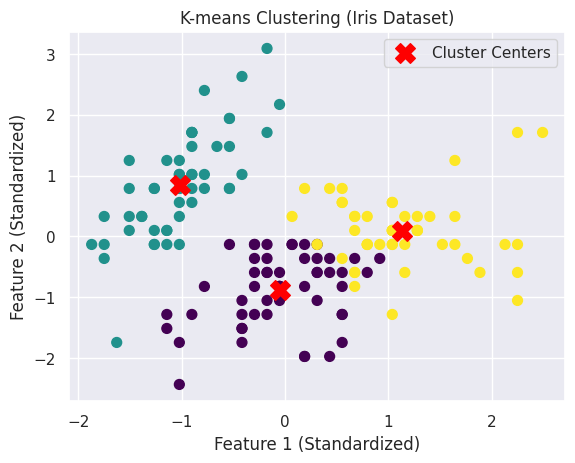

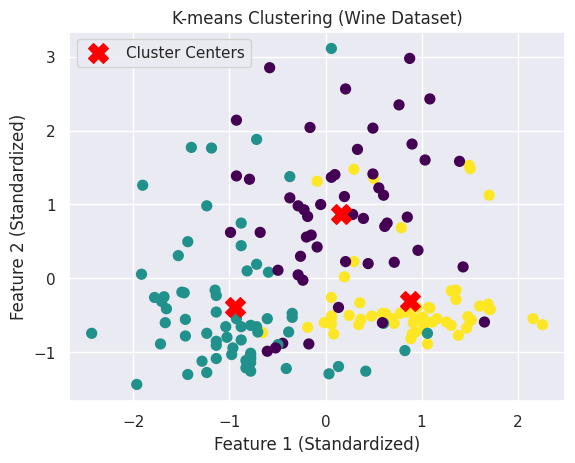

Cluster Sizes: {0: 492567, 1: 2, 2: 970, 3: 53, 4: 429}


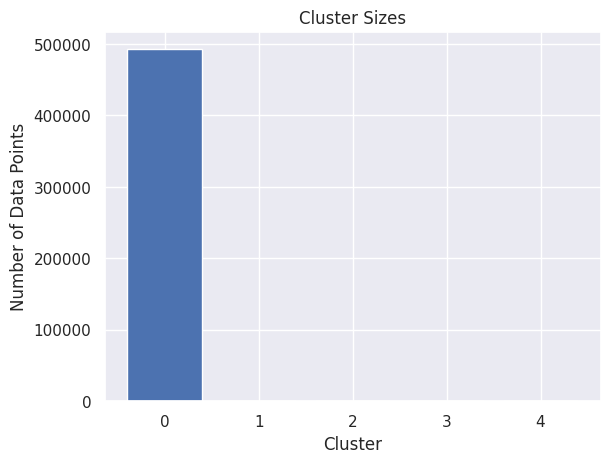

In [15]:
# Specify the number of clusters (k)
k = 3
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
# Standardize the features (optional, but often recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit K-means to the data
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)
# Plot the clustering results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('K-means Clustering (Iris Dataset)')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()
# Load the Wine dataset
wine = datasets.load_wine()
X = wine.data
# Standardize the features (optional, but often recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit K-means to the data
kmeans = KMeans(n_clusters=k, random_state=0)
cluster_labels = kmeans.fit_predict(X_scaled)
# Plot the clustering results
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('K-means Clustering (Wine Dataset)')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Load the KDD99 dataset
kdd_data = datasets.fetch_kddcup99()
# Extract the features (numerical and categorical columns) from the dataset
X = kdd_data.data
# Identify categorical columns in the dataset (you may need to adjust this based on your dataset)
categorical_columns = [1, 2, 3, 6, 11, 20, 21]
# Create a column transformer to handle both numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [0, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]),
        ('cat', OneHotEncoder(), categorical_columns)
    ])
# Create a pipeline that includes preprocessing and K-means clustering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=5, random_state=0))
])
# Fit K-means to the data
cluster_labels = pipeline.fit_predict(X)
# Print the count of data points in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster Sizes:", cluster_sizes)
# Plot the distribution of cluster sizes
plt.bar(cluster_sizes.keys(), cluster_sizes.values())
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Sizes')
plt.show()

**Q14.** Have a look at the feature selection methods provided by Scikit learn (see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).

For example, it is possible to reshape a dataset based on the 'best' features depending on some criterion of univariate correlation between a feature and the class.

```Python
# select the 2 most interesting features with chi2 criterion and project dataset X into the new space
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
```

Another option is to perform a projection of the input space into a space that preserves the distances via Multi Dimensional Scaling. This can be done in Python - on relatively small datasets - `via sklearn.manifold.MDS`
(https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)

```Python
from sklearn.manifold import MDS
embedding = MDS(n_components=2) # for 2 dimensions
X_new = embedding.fit_transform(X)
```

In [ ]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import MDS

# Load the KDD99 dataset
kdd_data = datasets.fetch_kddcup99(subset="SA", percent10=True, shuffle=True, random_state=0)
# Extract the features (numerical and categorical columns) from the dataset
X = kdd_data.data
y = kdd_data.target
# Identify categorical columns in the dataset (you may need to adjust this based on your dataset)
categorical_columns = [1, 2, 3, 6, 11, 20, 21]
# Create a column transformer to handle both numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), [0, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]),
        ('cat', OneHotEncoder(), categorical_columns)
    ])
# Apply feature selection to select the top k most important features based on chi-squared criterion
k = 10
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_new = SelectKBest(chi2, k=k).fit_transform(preprocessor.fit_transform(X), y_encoded)
# Perform Multi-Dimensional Scaling (MDS) to project the data into a lower-dimensional space
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X_new.toarray())
# Specify the number of clusters (k) for K-means
k = 23  # You can adjust the number of clusters as needed
# Fit K-means to the original data
kmeans_original = KMeans(n_clusters=k, random_state=0)
cluster_labels_original = kmeans_original.fit_predict(X)
# Fit K-means to the selected feature space
kmeans_selected = KMeans(n_clusters=k, random_state=0)
cluster_labels_selected = kmeans_selected.fit_predict(X_new)
# Fit K-means to the MDS-projected feature space
kmeans_mds = KMeans(n_clusters=k, random_state=0)
cluster_labels_mds = kmeans_mds.fit_predict(X_mds)
# Plot the K-means clustering results for original, selected, and MDS spaces
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_original, cmap='viridis', s=50)
plt.title('K-means Clustering (Original Space)')
plt.subplot(132)
plt.scatter(X_new[:, 0], X_new[:, 1], c=cluster_labels_selected, cmap='viridis', s=50)
plt.title('K-means Clustering (Selected Features)')
plt.subplot(133)
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=cluster_labels_mds, cmap='viridis', s=50)
plt.title('K-means Clustering (MDS Space)')
plt.tight_layout()
plt.show()

## 5. Hierarchical clustering

We now focus on two implementations of the hierarchical clustering.
- the first one comes from `scipy` with the library `scipy.cluster.hierarchy` and the method `linkage` and most importantly the visualization routine `dendrogram` or the `fcluster` method that provides the cluster labels based on some cut distance in the dendrogram
- the second one comes from `sklearn` with the library `sklearn.cluster.AgglomerativeClustering` and as such provides more easily the discovered labels for an evaluation.

**Q15.** Evaluate each of these two implementations in different scenarios: generate either well separated clusters or more elongated clusters that connects at some point.
The idea is to understand when and why you should use some specific agregation criterion among single link and complete link.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

# Helper function to plot clustering results
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

# Generate well-separated clusters
X, y = make_blobs(n_samples=300, centers=3, random_state=0, cluster_std=1.0)
# Generate elongated clusters using make_moons
#X, y_elonygated = make_moons(n_samples=300, noise=0.05, random_state=0)

# Scenario 1: Well-Separated Clusters

# Perform hierarchical clustering with single-linkage and complete-linkage
# using scipy's linkage
linkage_single = linkage(X, method='single')
linkage_complete = linkage(X, method='complete')
# Plot dendrograms for both methods
plt.figure(figsize=(12, 6))
plt.subplot(121)
dendrogram(linkage_single)
plt.title('Single-Linkage Dendrogram')
plt.subplot(122)
dendrogram(linkage_complete)
plt.title('Complete-Linkage Dendrogram')
plt.show()
# Apply hierarchical clustering using scipy's fcluster
# Choose a threshold for cutting the dendrogram
threshold = 4.0
labels_single = fcluster(linkage_single, threshold, criterion='distance')
labels_complete = fcluster(linkage_complete, threshold, criterion='distance')
# Plot clustering results
plot_clusters(X, labels_single, 'Single-Linkage Clustering')
plot_clusters(X, labels_complete, 'Complete-Linkage Clustering')

# Scenario 2: Elongated Clusters
# Perform hierarchical clustering with single-linkage and complete-linkage
# using sklearn's AgglomerativeClustering
agg_single = AgglomerativeClustering(n_clusters=2, linkage='single')
agg_complete = AgglomerativeClustering(n_clusters=2, linkage='complete')
# Fit and predict with AgglomerativeClustering
labels_single = agg_single.fit_predict(X)
labels_complete = agg_complete.fit_predict(X)
# Plot clustering results
plot_clusters(X, labels_single, 'Single-Linkage Clustering')
plot_clusters(X, labels_complete, 'Complete-Linkage Clustering')

**Q16.** How the 'average' linkage criterion compares to a k-means clustering?

Do not forget that the `sklearn.datasets` that contains plenty of methods to generate strange shapes of clusters to evaluate your algorithms.

In [ ]:
# Generate synthetic data with three well-separated clusters
X, y = make_blobs(n_samples=300, centers=3, random_state=0, cluster_std=1.0)
# Perform hierarchical clustering with 'average' linkage
agg_cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
agg_labels = agg_cluster.fit_predict(X)
# Perform k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
# Plot the results
plt.figure(figsize=(12, 5))
# Plot hierarchical clustering results
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=agg_labels, cmap='viridis', s=50)
plt.title('Hierarchical Clustering (Average Linkage)')
# Plot k-means clustering results
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title('K-Means Clustering')
plt.show()

**Q17.** Use `make_moons` or `make_circles` to generate more complex data and observe how this degrades the performances of k-means versus hierarchical clustering depending on the agregation criterion

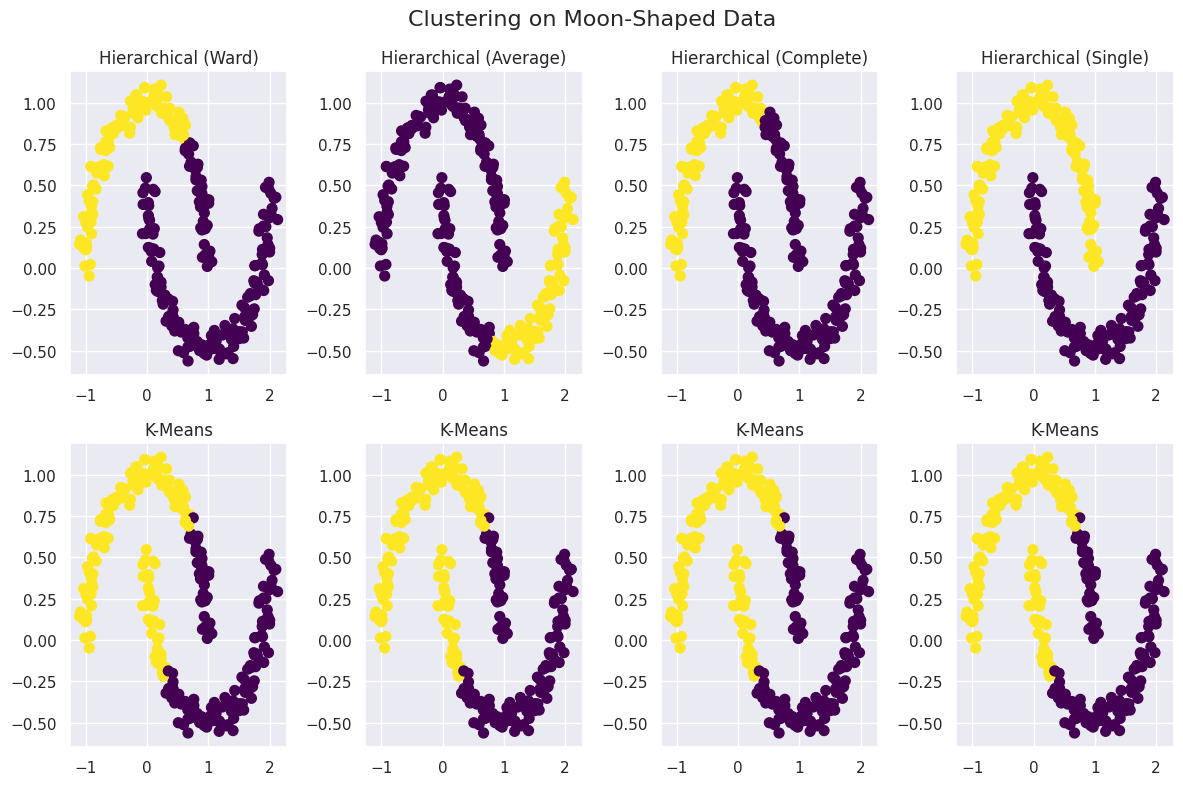

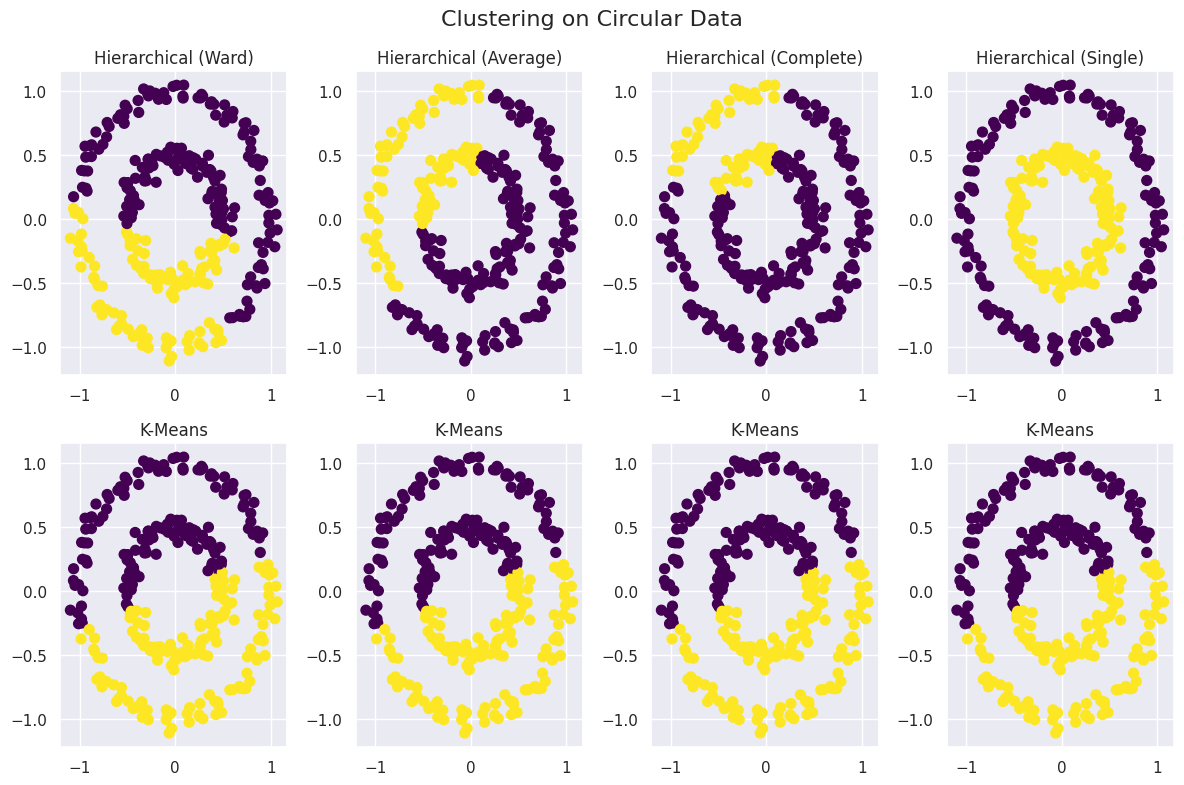

In [7]:
from sklearn.datasets import make_circles

# Generate complex moon-shaped data
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)
# Generate complex circular data
X_circles, y_circles = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)
# Perform clustering and visualization for moon-shaped data
linkage_methods = ['ward', 'average', 'complete', 'single']
n_clusters = 2
plt.figure(figsize=(12, 8))
plt.suptitle('Clustering on Moon-Shaped Data', fontsize=16)
for i, linkage in enumerate(linkage_methods):
    # Hierarchical clustering
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    agg_labels = agg_cluster.fit_predict(X_moons)
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = kmeans.fit_predict(X_moons)
    # Plot results
    plt.subplot(2, 4, i + 1)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=agg_labels, cmap='viridis', s=50)
    plt.title(f'Hierarchical ({linkage.capitalize()})')
    plt.subplot(2, 4, i + 5)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=kmeans_labels, cmap='viridis', s=50)
    plt.title('K-Means')
plt.tight_layout()
plt.show()

# Perform clustering and visualization for circular data
plt.figure(figsize=(12, 8))
plt.suptitle('Clustering on Circular Data', fontsize=16)
for i, linkage in enumerate(linkage_methods):
    # Hierarchical clustering
    agg_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    agg_labels = agg_cluster.fit_predict(X_circles)
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_labels = kmeans.fit_predict(X_circles)
    # Plot results
    plt.subplot(2, 4, i + 1)
    plt.scatter(X_circles[:, 0], X_circles[:, 1], c=agg_labels, cmap='viridis', s=50)
    plt.title(f'Hierarchical ({linkage.capitalize()})')
    plt.subplot(2, 4, i + 5)
    plt.scatter(X_circles[:, 0], X_circles[:, 1], c=kmeans_labels, cmap='viridis', s=50)
    plt.title('K-Means')
plt.tight_layout()
plt.show()

## 6. Density-based clustering

We finally focus on the density-based clustering DB-SCAN as implemented in `sklearn.cluster.DBSCAN`.

You may find interesting information and a possible density visualization at https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
    

**Q18.** Generate 3 datasets with the following properties: 1. one where k-means and DB-SCAN succeed, 2. one where only k-means succeeds, 3. one where only DB-SCAN succeeds and explain why you generate these datasets. Additionally, explain which algorithm parameters you choose. The aforementioned properties have to be observed for the best possible set of parameters of each algorithm (ie. in a fair setting).

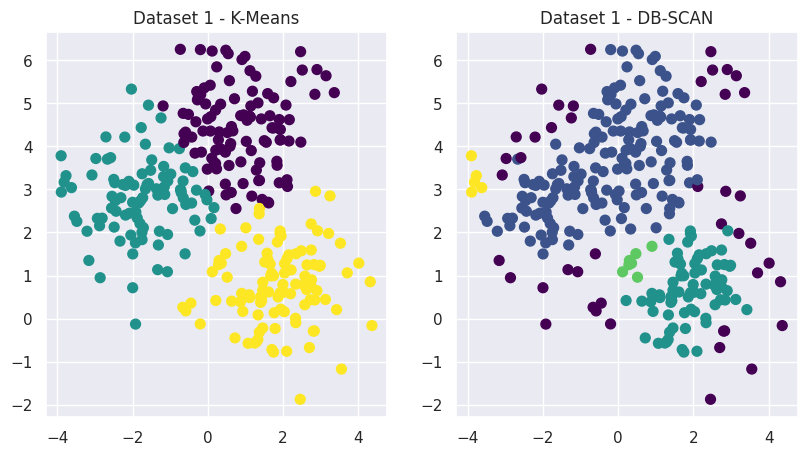

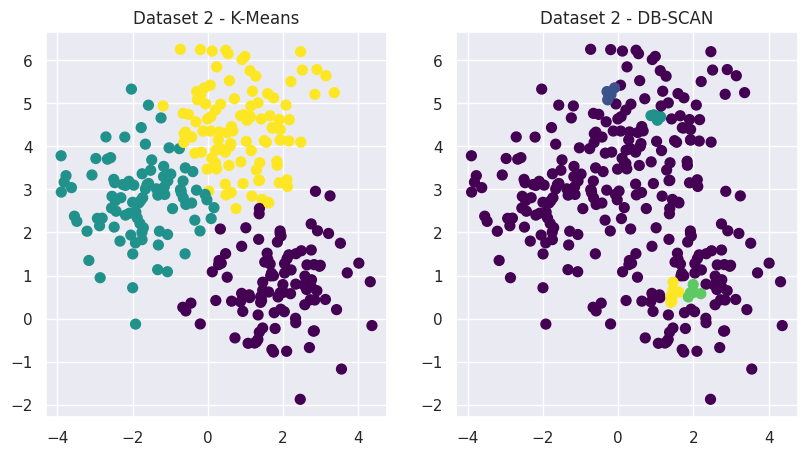

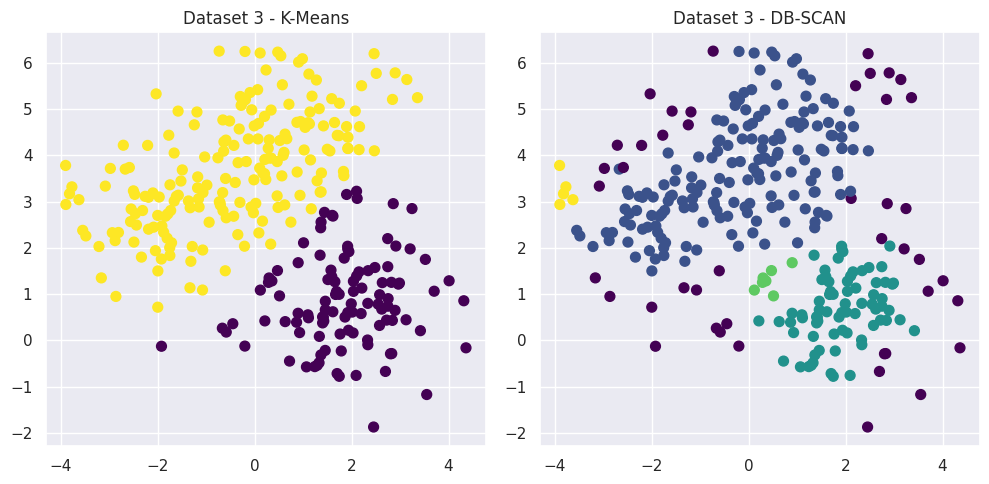

In [12]:
from sklearn.cluster import DBSCAN

# Dataset 1: Where Both K-Means and DB-SCAN Succeed
X1, y1 = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=0)
# Parameters for K-Means
kmeans1 = KMeans(n_clusters=3)
kmeans_labels1 = kmeans1.fit_predict(X1)
# Parameters for DB-SCAN
dbscan1 = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels1 = dbscan1.fit_predict(X1)

# Dataset 2: Where Only K-Means Succeeds
X2, y2 = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=0)
# Parameters for K-Means
kmeans2 = KMeans(n_clusters=3)
kmeans_labels2 = kmeans2.fit_predict(X2)
# Parameters for DB-SCAN
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels2 = dbscan2.fit_predict(X2)

# Dataset 3: Where Only DB-SCAN Succeeds
X3, y3 = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=0)
# Parameters for K-Means
kmeans3 = KMeans(n_clusters=2)  # Wrong number of clusters
kmeans_labels3 = kmeans3.fit_predict(X3)
# Parameters for DB-SCAN
dbscan3 = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels3 = dbscan3.fit_predict(X3)

# Plot the datasets and clustering results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X1[:, 0], X1[:, 1], c=kmeans_labels1, cmap='viridis', s=50)
plt.title('Dataset 1 - K-Means')
plt.subplot(132)
plt.scatter(X1[:, 0], X1[:, 1], c=dbscan_labels1, cmap='viridis', s=50)
plt.title('Dataset 1 - DB-SCAN')
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X2[:, 0], X2[:, 1], c=kmeans_labels2, cmap='viridis', s=50)
plt.title('Dataset 2 - K-Means')
plt.subplot(132)
plt.scatter(X2[:, 0], X2[:, 1], c=dbscan_labels2, cmap='viridis', s=50)
plt.title('Dataset 2 - DB-SCAN')
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X3[:, 0], X3[:, 1], c=kmeans_labels3, cmap='viridis', s=50)
plt.title('Dataset 3 - K-Means')
plt.subplot(132)
plt.scatter(X3[:, 0], X3[:, 1], c=dbscan_labels3, cmap='viridis', s=50)
plt.title('Dataset 3 - DB-SCAN')
plt.tight_layout()
plt.show()

**Q19.** On the dataset where k-means does not succeed, can you evaluate the quality of DB-SCAN based on Adjusted Rand Index? Same question with Silhouette coefficient?

In [14]:
from sklearn.metrics import silhouette_score

# Evaluate DB-SCAN using Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(y2, dbscan_labels2)
print(f"Adjusted Rand Index (ARI) for DB-SCAN: {ari_score}")
# Evaluate DB-SCAN using Silhouette coefficient
# Note: Silhouette score requires samples to have at least 2 clusters, so we'll exclude outliers (-1 label)
silhouette_avg = silhouette_score(X2, dbscan_labels2, sample_size=300)  # Exclude outliers
print(f"Silhouette coefficient for DB-SCAN: {silhouette_avg}")

Adjusted Rand Index (ARI) for DB-SCAN: 0.004924344596611705
Silhouette coefficient for DB-SCAN: -0.3613879279917052


1. if we want k-means and DB-SCAN to succeed, we need: spherical clusters (k-means), well-separated (k-means), with the same density (DB-SCAN). For example 3 blobs with the same variance, well separated should be okay

2. if we want only k-means to succeed, we have to generate (at least) 2 well-separated clusters, hyper-spherical but with different densities (radius). The larger cluster should have a radius smaller than half the size between the two cluster centers. For example, if we consider cluster A and B, radius of the largest cluster should be < d(A,B) / 2 (otherwise k-means will consider that a part of the largest cluster belongs to the smallest one).

3. if we want only dbscan to succeed, we just have to keep elongated clusters just like those obtained by the anisotropic transform.

Yes adjusted rand index does not make any assumption about the shape of clusters. Only the distribution of pairs of points is relevant (and so is the number of clusters).
